In [12]:
#Geo libraries
import rasterio
import geopandas as gpd
from osgeo import gdal
from osgeo import osr
from osgeo import ogr 
import shapefile
import rasterstats as rs

#Standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#Python base libraries
import re
import glob
import multiprocessing as mp

import numba
from numba import jit

import swifter
from numba import cuda

import dask.dataframe as dd
from dask.multiprocessing import get
import dask.bag as db

from scipy import signal
import scipy

In [48]:
%%time
pointsfile="AUS_points_5km.shp"
sjer_plots_points = gpd.read_file(pointsfile)
#sjer_plots_points=sjer_plots_points.iloc[::10, :]
# Create a buffered polygon layer from your plot location points
#sjer_plots_poly = sjer_plots_points.copy()
# Buffer each point using a 700 meter circle radius
# and replace the point geometry with the new buffered geometry
#sjer_plots_poly["geometry"] = sjer_plots_points.geometry.buffer(700)
#sjer_plots_poly.head()

Wall time: 12.9 s


In [3]:
#sjer_plots_points=sjer_plots_points.iloc[::100, :]

<AxesSubplot:>

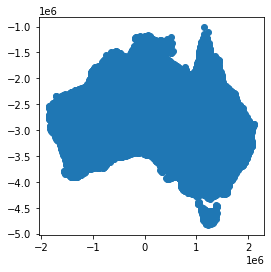

In [35]:
sjer_plots_points.plot()

In [3]:
folder="ABS1x1km_Aus_Pop_Grid_2006_2020/data_provided/"
tiffile="apg06e_f_001_20210512.tif"

In [5]:
# %%time
# ##RASTERIO
# src = rasterio.open(folder+tiffile)
# array_rasterio = src.read(1)
# nodataval= src.nodatavals

# if np.any(array_rasterio == nodataval):
#     array_rasterio[array_rasterio == nodataval] = np.nan
    
# print(np.shape(array_rasterio))

In [6]:
# plt.imshow(array_rasterio,vmin=0,vmax=1)
# plt.show()

In [11]:
%%time
##GDAL
gdal_data = gdal.Open(folder+tiffile)
gdal_band = gdal_data.GetRasterBand(1)
nodataval = gdal_band.GetNoDataValue()
array_gdal = gdal_data.ReadAsArray().astype(np.float)
gt = gdal_data.GetGeoTransform()

if np.any(array_gdal == nodataval):
    array_gdal[array_gdal == nodataval] = np.nan
    
print(np.shape(array_gdal))

(4100, 7401)
Wall time: 887 ms


In [46]:
import numpy as np
from scipy.signal import convolve2d
from scipy.ndimage import generic_filter
import time


def buffer_neighbor_average_generic_filter(x,buffer):
    footprint = create_buffer(buffer)

    result = generic_filter(
        x.astype('float'), np.nanmean, footprint=footprint,
        mode='constant', cval=np.nan)

    return result

def buffer_convolve2d(x,buffer):
    kernel = create_buffer(buffer)

    neighbor_sum = convolve2d(
        x, kernel, mode='same',
        boundary='fill', fillvalue=0)

    num_neighbor = convolve2d(
        np.ones(x.shape), kernel, mode='same',
        boundary='fill', fillvalue=0)

    return neighbor_sum / num_neighbor


if __name__ == '__main__':
   
    #t0 = time.time()
    #y1_large = buffer_neighbor_average_generic_filter(array_gdal,10)
    #t_generic_filter = time.time() - t0

    t0 = time.time()
    y2_large = buffer_convolve2d(array_gdal,10)
    t_convolve2d = time.time() - t0

    print('\nExecution times for "large" array:')
    print('    generic filter: %f s' % t_generic_filter)
    print('    convolve2d: %f s' % t_convolve2d)


Execution times for "large" array:
    generic filter: 1182.552415 s
    convolve2d: 17.357236 s


In [112]:
buff=10000
print(gt[1])

1000.0


In [113]:
b=int(np.ceil(buff/gt[1]))
print(b)
z=np.ones((b,b))

z
print(z)
#x2+y2=r
#dist_from_center = np.sqrt((X)**2 + (Y-center[1])**2)

#    mask = dist_from_center <= radius

10
[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]


In [121]:
z[0]=np.nan
z[4,5]=np.nan
from scipy.ndimage import convolve

In [122]:
kernel=np.ones((2,2))
print(kernel)

[[1. 1.]
 [1. 1.]]


In [123]:
z

array([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1., nan,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.]])

In [125]:
convolve(np.ones(z.shape), kernel, mode='reflect', cval=0)

array([[4., 4., 4., 4., 4., 4., 4., 4., 4., 4.],
       [4., 4., 4., 4., 4., 4., 4., 4., 4., 4.],
       [4., 4., 4., 4., 4., 4., 4., 4., 4., 4.],
       [4., 4., 4., 4., 4., 4., 4., 4., 4., 4.],
       [4., 4., 4., 4., 4., 4., 4., 4., 4., 4.],
       [4., 4., 4., 4., 4., 4., 4., 4., 4., 4.],
       [4., 4., 4., 4., 4., 4., 4., 4., 4., 4.],
       [4., 4., 4., 4., 4., 4., 4., 4., 4., 4.],
       [4., 4., 4., 4., 4., 4., 4., 4., 4., 4.],
       [4., 4., 4., 4., 4., 4., 4., 4., 4., 4.]])

In [128]:
scipy.signal.convolve2d(np.ones(z.shape), kernel, mode='same')

array([[1., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
       [2., 4., 4., 4., 4., 4., 4., 4., 4., 4.],
       [2., 4., 4., 4., 4., 4., 4., 4., 4., 4.],
       [2., 4., 4., 4., 4., 4., 4., 4., 4., 4.],
       [2., 4., 4., 4., 4., 4., 4., 4., 4., 4.],
       [2., 4., 4., 4., 4., 4., 4., 4., 4., 4.],
       [2., 4., 4., 4., 4., 4., 4., 4., 4., 4.],
       [2., 4., 4., 4., 4., 4., 4., 4., 4., 4.],
       [2., 4., 4., 4., 4., 4., 4., 4., 4., 4.],
       [2., 4., 4., 4., 4., 4., 4., 4., 4., 4.]])

In [47]:
%%time
y2_large = buffer_convolve2d(array_gdal,10)

17.7 s ± 423 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [51]:
%%time
sjer_plots_points["ind"] = sjer_plots_points.apply(lambda x: get_coords_at_point(gt, x.geometry.x, x.geometry.y), axis=1)

Wall time: 49.8 s


In [55]:
sjer_plots_points["ind"]

0           (12, 5052)
1           (12, 5057)
2           (17, 5057)
3           (17, 5062)
4           (32, 5102)
              ...     
307499    (3832, 5127)
307500    (3832, 5132)
307501    (3832, 5137)
307502    (3832, 5142)
307503    (3837, 5142)
Name: ind, Length: 307504, dtype: object

In [77]:
#np.take(y2_large,(12, 5057))
sjer_plots_points.ind.loc[287914]
np.take(array_gdal,2832, 5662)

array([nan, nan])

In [78]:
array_gdal[2832,5662]

2113.18603515625

In [79]:
sjer_plots_points['Raster'] = [y2_large[x] for x in sjer_plots_points["ind"]]

In [83]:
sjer_plots_points['Raster'].values

array([nan, nan, nan, ..., nan, nan, nan])

In [ ]:
For each buffer
Run convolve
For each point querey ocnvolution
Get index for each point and querey point

In [45]:
def create_buffer(r, center=None, radius=None):

    if center is None: # use the middle of the image
        center = (int(r/2), int(r/2))
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], r-center[0], r-center[1])

    Y, X = np.ogrid[:r, :r]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask*1.0

In [21]:
buff=create_buffer(10)

In [23]:
gdal_buffed=scipy.ndimage.convolve(gdal_data, buff, mode='constant', cval=0.0)

RuntimeError: filter weights array has incorrect shape.

In [9]:
gdal_data.GetMetadata_List("LAYERS")

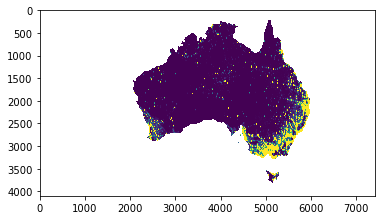

In [5]:
plt.imshow(array_gdal,vmin=0,vmax=1)
plt.show()

In [12]:
# %%time
# def returnValuePoints(x, y):
#     point = (x, y)
#     col = int((point[0] - -3901000.0) /1000.0)
#     row = int((point[1] - -1000000.0) / -1000.0)
#     return (row, col)

# sjer_plots_points["ind"] = sjer_plots_points.apply(lambda x: returnValuePoints(x.geometry.x, x.geometry.y), axis=1)

In [91]:
def coregPoint(point,data,region):
    '''
    Finds the nearest neighbour to a point from a bunch of other points
    point - array([longitude,latitude])
    data - array
    region - integer, same units as data
    '''
    tree = scipy.spatial.cKDTree(data)
    dists, indexes = tree.query(point,k=1,distance_upper_bound=region) 

    if indexes==len(data):
        return 'inf'
    else:
        return (indexes,dists)
    

@jit(nopython=True)
def points_in_circle(circle, arr):
    '''
    A generator to return all points whose indices are within given circle.
    Inspired from http://stackoverflow.com/a/2774284
    Global raster warning: If a point is near the the edges of the raster it will not loop 
    around to the other side of the raster!
    '''
    i0,j0,r = circle
    
    def intceil(x):
        return int(np.ceil(x))
    
    for i in range(intceil(i0-r),intceil(i0+r)):
        ri = np.sqrt(r**2-(i-i0)**2)
        for j in range(intceil(j0-ri),intceil(j0+ri)):
            if (i >= 0 and i < len(arr[:,0])) and (j>=0 and j < len(arr[0,:])):               
                yield arr[i][j]

# 
def coregRaster(j0,i0,data,region):
    '''
    Finds the mean value of a raster, around a point with a specified radius.
    point - array([longitude,latitude])
    data - array
    region - integer in index units
    '''
    pts_iterator = points_in_circle((i0,j0,region), data)
    pts = np.array(list(pts_iterator))   
    squares= np.count_nonzero(~np.isnan(pts))

    #return(scipy.stats.nanmean(pts)) #deprecated from scipy 0.15
    return(np.nansum(pts),squares)

@jit(nopython=True)
def coregRasterSquare(j0,i0,data,region):
    '''
    Finds the mean value of a raster, around a point with a specified radius.
    point - array([longitude,latitude])
    data - array
    region - integer in index units
    '''
    minx=j0-region
    maxx=j0+region
    miny=i0-region
    maxy=i0+region
    
    arrshp = np.shape(data)
    
    if minx < 0:
        minx = 0
    if maxx > arrshp[0]:
        maxx = arrshp[0]
    if miny < 0:
        miny = 0
    if maxy > arrshp[1]:
        maxy = arrshp[1]
        
    pts=data[minx:maxx,miny:maxy] 
    squares= np.count_nonzero(~np.isnan(pts))

    return(np.nansum(pts),squares)

  

#############
@cuda.jit
def coregRasterCUDA(j0,i0,r):
    '''
    Finds the mean value of a raster, around a point with a specified radius.
    point - array([longitude,latitude])
    data - array
    r - integer in index units
    '''
    
    def intceil(x):
        return int(np.ceil(x))
    
    def points_in_circle(i0,j0,r):
        for i in range(intceil(i0-r),intceil(i0+r)):
            ri = np.sqrt(r**2-(i-i0)**2)
            for j in range(intceil(j0-ri),intceil(j0+ri)):
                if (i >= 0 and i < len(cudarr[:,0])) and (j>=0 and j < len(cudarr[0,:])):               
                    return cudarr[i][j]
                
    pts_iterator = points_in_circle(i0,j0,r)
    
    pts = np.array(list(pts_iterator)) 
    
    squares= np.count_nonzero(~np.isnan(pts))

    #return(scipy.stats.nanmean(pts)) #deprecated from scipy 0.15
    return(np.nansum(pts),squares)




@jit(nopython=True)
def get_coords_at_point(gt, lon, lat):
    row = int((lon - gt[0])/gt[1])
    col = int((lat - gt[3])/gt[5])
    return (col, row)

In [75]:
cudarr = cuda.to_device(sjer_plots_points)

In [20]:
%%time

#threadsperblock = 32
#blockspergrid = (sjer_plots_points.size + (threadsperblock - 1)) // threadsperblock

#pop_area = sjer_plots_points.apply(lambda x: coregRasterCUDA[blockspergrid, threadsperblock](x.ind[0], x.ind[1],7), axis=1)

Wall time: 0 ns


In [61]:
%%time
sjer_plots_points["ind"] = sjer_plots_points.apply(lambda x: get_coords_at_point(gt, x.geometry.x, x.geometry.y), axis=1)

Wall time: 50.4 s


In [ ]:
# %%time
# for row in sjer_plots_points.itertuples():
# sjer_plots_points["ind"] = sjer_plots_points.apply(lambda x: get_coords_at_point(gt, x.geometry.x, x.geometry.y), axis=1)

In [37]:
%%time
pop_area = sjer_plots_points.apply(lambda x: coregRaster(x.ind[0], x.ind[1],array_gdal,7), axis=1)

Wall time: 6.08 s


In [38]:
%%time
pop_area = sjer_plots_points.apply(lambda x: coregRasterSquare(x.ind[0], x.ind[1],array_gdal,7), axis=1)

Wall time: 4.12 s


In [53]:
sjer_plots_points.ind[10][0]

102

In [64]:
np.shape(sjer_plots_points)

(307504, 3)

In [62]:
%%time
for row in sjer_plots_points.itertuples():
    pop_area = coregRasterSquare(row.ind[0], row.ind[1],array_gdal,7)

Wall time: 1.47 s


In [63]:
%%time
for row in sjer_plots_points.itertuples():
    pop_area = coregRaster(row.ind[0], row.ind[1],array_gdal,7)

Wall time: 11.5 s


In [49]:
%%time
pop_area = sjer_plots_points.swifter.set_npartitions(16).apply(lambda x: coregRaster(x.ind[0], x.ind[1],array_gdal,7), axis=1)

Dask Apply:   0%|          | 0/16 [00:00<?, ?it/s]

Wall time: 1min 44s


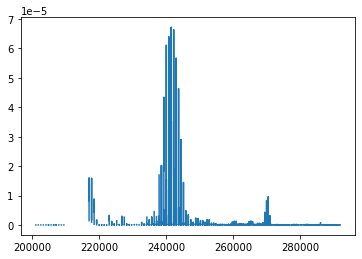

In [12]:
sjer_plots_points[['pop', 'area']] = pd.DataFrame(pop_area.tolist(), index=pop_area.index)
sjer_plots_points["pop_density"]=sjer_plots_points["pop"]/(sjer_plots_points["area"]*5000**2)
plt.plot(sjer_plots_points["pop_density"])

In [13]:
len(sjer_plots_points)

307504

In [41]:
cpus = mp.cpu_count()
print(cpus)
#pool = mp.Pool(processes=cpus)

8


In [13]:
def neighbour_distance(gdf_chunk):
    gdf_chunk.apply(lambda x: coregRaster(x.ind[0], x.ind[1],array_gdal,7), axis=1)

In [43]:
#intersection_chunks = np.array_split(sjer_plots_points, cpus)
#intersection_chunks = np.array_split(sjer_plots_points.ind, cpus)
ddata = dd.from_pandas(sjer_plots_points, npartitions=cpus)

In [44]:
res = ddata.map_partitions(lambda x: x.apply(lambda x: coregRaster(x.ind[0], x.ind[1],array_gdal,7), axis=1)).compute(get=get)  

ValueError: Metadata inference failed in `lambda`.

You have supplied a custom function and Dask is unable to 
determine the type of output that that function returns. 

To resolve this please provide a meta= keyword.
The docstring of the Dask function you ran should have more information.

Original error is below:
------------------------
TypeError('data type not understood')

Traceback:
---------
  File "c:\users\nbutter\miniconda3\envs\geopy\lib\site-packages\dask\dataframe\utils.py", line 176, in raise_on_meta_error
    yield
  File "c:\users\nbutter\miniconda3\envs\geopy\lib\site-packages\dask\dataframe\core.py", line 5580, in _emulate
    return func(*_extract_meta(args, True), **_extract_meta(kwargs, True))
  File "c:\users\nbutter\miniconda3\envs\geopy\lib\site-packages\dask\dataframe\core.py", line 5560, in _extract_meta
    return tuple([_extract_meta(_x, nonempty) for _x in x])
  File "c:\users\nbutter\miniconda3\envs\geopy\lib\site-packages\dask\dataframe\core.py", line 5560, in <listcomp>
    return tuple([_extract_meta(_x, nonempty) for _x in x])
  File "c:\users\nbutter\miniconda3\envs\geopy\lib\site-packages\dask\dataframe\core.py", line 5556, in _extract_meta
    return x._meta_nonempty if nonempty else x._meta
  File "c:\users\nbutter\miniconda3\envs\geopy\lib\site-packages\dask\dataframe\core.py", line 379, in _meta_nonempty
    return meta_nonempty(self._meta)
  File "c:\users\nbutter\miniconda3\envs\geopy\lib\site-packages\dask\utils.py", line 512, in __call__
    return meth(arg, *args, **kwargs)
  File "c:\users\nbutter\miniconda3\envs\geopy\lib\site-packages\dask\dataframe\backends.py", line 172, in meta_nonempty_dataframe
    dt_s_dict[dt] = _nonempty_series(x.iloc[:, i], idx=idx)
  File "c:\users\nbutter\miniconda3\envs\geopy\lib\site-packages\dask\dataframe\backends.py", line 287, in _nonempty_series
    data = np.array([entry, entry], dtype=dtype)


In [17]:
intersection_chunks = np.array_split(sjer_plots_points.ind, cpus)

In [18]:
np.shape(intersection_chunks[0])

(38438,)

In [22]:
type(intersection_chunks[0])

pandas.core.series.Series

In [40]:
pool = mp.Pool(processes=cpus)
chunk_processes=[pool.apply_async(neighbour_distance, args=(intersection_chunks)) for chunk in intersection_chunks]

In [ ]:
intersection_results = [chunk.get() for chunk in chunk_processes]

In [ ]:

    
    
    chunk_processes = [pool.apply_async(neighbour_distance, args=(intersection_chunks)) for chunk in intersection_chunks]
    
    intersection_results = [chunk.get() for chunk in chunk_processes]
    
#intersections_dist = gpd.GeoDataFrame(pd.concat(intersection_results), crs=sjer_plots_points.crs)
#return intersection_results

In [ ]:
%%time
intersection_results = parallelize()

In [60]:
x=sjer_plots_points.geometry.x[500]
y=sjer_plots_points.geometry.y[500]


In [83]:
proj = osr.SpatialReference(wkt=gdal_data.GetProjection())

In [79]:
gt

(-3901000.0, 1000.0, 0.0, -1000000.0, 0.0, -1000.0)

In [74]:
%%time
#val = df.apply(lambda x: coregRaster(sjer_plots_points.geometry.x, sjer_plots_points.geometry.y,700,array), axis=1)

radius = 7

col,row = get_coords_at_point(gt, x,y)
buff_arr = coregRaster(row, col,array_gdal,radius)

Wall time: 0 ns


In [90]:
print(np.count_nonzero(~np.isnan(array_gdal)))

print(area)

7690678
50.0


In [86]:
prj = gdal_data.GetProjection()
print(prj)

PROJCS["GDA_1994_Albers",GEOGCS["GDA94",DATUM["Geocentric_Datum_of_Australia_1994",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6283"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",0],PARAMETER["longitude_of_center",132],PARAMETER["standard_parallel_1",-18],PARAMETER["standard_parallel_2",-36],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]


In [99]:
coords=shapes[0].points[0]

def get_coords_at_point(rasterfile, pos):
    gdata = gdal.Open(rasterfile)
    gt = gdata.GetGeoTransform()
    data = gdata.ReadAsArray().astype(np.float)
    row = int((pos[1] - gt[0])/gt[1])
    col = int((pos[0] - gt[3])/gt[5])
    return col, row

radius = 700 # in units of pixels

row, col = get_coords_at_point(tiffile, pos = coords) 
circle = (row, col, radius)

In [100]:
circle

(-2151, 2888, 700)

In [101]:
def points_in_circle(circle, arr):
    buffer_points = []
    i0, j0, r = circle
    
    def int_ceiling(x):
        return int(np.ceil(x))
    
    for i in range(int_ceiling(i0 - r), int_ceiling(i0 + r)):
        ri = np.sqrt(r**2 - (i - i0)**2)
        
        for j in range(int_ceiling(j0 - ri), int_ceiling(j0 + ri)):
            buffer_points.append(arr[i][j])
            arr[i][j] = np.nan
    
    return buffer_points

buffer_points = points_in_circle(circle, data_array)

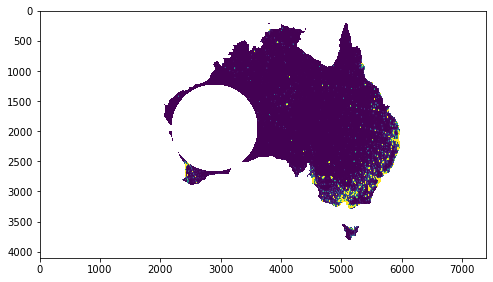

In [113]:
fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(111)
#plt.axis("off")
plt.imshow(data_array, cmap = "viridis",vmin=0,vmax=10)
#plt.plot(coords[0],coords[1],'kx')
plt.show()

In [114]:
mean = np.nanmean(buffer_points)
std = np.nanstd(buffer_points)
variance = np.nanvar(buffer_points)
summ = np.nansum(buffer_points)

In [117]:
variance

32.05252805112663

In [25]:
%%time


## Read in population rasters
poprasts = glob.glob('ABS1x1km_Aus_Pop_Grid_2006_2020/' +
                     'data_provided/apg07e_f_001_20210512.tif')

grid = gpd.read_file('AUS_points_5km.shp')

## Add an FID in there - if one doesn't already exist
grid.insert(0, 'FID', range(1, len(grid) + 1))


## To see how long it takes

Wall time: 27.8 s


In [26]:
## Define a 'sumna' function that removes missing, and any negative values
def sumna(x):
    return np.nansum(x[x>0])

## Function for one year's extract
def popbuff(buff):
    b = grid.geometry.buffer(buff)
    pop = rs.zonal_stats(b,
                         poprast.read(1),
                         nodata = 0,
                         affine = poprast.transform,
                         stats = 'sum',
                         add_stats = {'sumna' : sumna})
    out = gpd.GeoDataFrame(pop)['sumna']
    out = out/(b.area/1e6)
    return out

buffs = [700] #, 1000, 1500, 2000, 3000, 5000, 10000]

In [32]:
with rasterio.open(poprasts[0]) as poprast:
        yr = str(20) + re.sub(".*(apg|APG)(\\d{2}).*", "\\2", poprasts[0])
        print(yr)
        popdf = list(map(popbuff, buffs))

2007


KeyboardInterrupt: 

In [36]:
with rasterio.open(poprasts[0]) as poprast:
    print(poprast)
    print(poprast.read(1))

<open DatasetReader name='ABS1x1km_Aus_Pop_Grid_2006_2020/data_provided/apg07e_f_001_20210512.tif' mode='r'>
[[-3.402823e+38 -3.402823e+38 -3.402823e+38 ... -3.402823e+38
  -3.402823e+38 -3.402823e+38]
 [-3.402823e+38 -3.402823e+38 -3.402823e+38 ... -3.402823e+38
  -3.402823e+38 -3.402823e+38]
 [-3.402823e+38 -3.402823e+38 -3.402823e+38 ... -3.402823e+38
  -3.402823e+38 -3.402823e+38]
 ...
 [-3.402823e+38 -3.402823e+38 -3.402823e+38 ... -3.402823e+38
  -3.402823e+38 -3.402823e+38]
 [-3.402823e+38 -3.402823e+38 -3.402823e+38 ... -3.402823e+38
  -3.402823e+38 -3.402823e+38]
 [-3.402823e+38 -3.402823e+38 -3.402823e+38 ... -3.402823e+38
  -3.402823e+38 -3.402823e+38]]


In [56]:

print(cuda.gpus)

<Managed Device 0>


In [55]:
import xrspatial

In [ ]:
from xrspatial import zonal_stats
zones_agg.values = np.nan_to_num(zones_agg.values, copy=False).astype(int)
zonal_stats(zones_agg, terrain)

In [65]:
poprasts = glob.glob('ABS1x1km_Aus_Pop_Grid_2006_2020/' +
                     'data_provided/apg07e_f_001_20210512.tif')

In [67]:
buffs=700

for pth in poprasts:
    with rasterio.open(pth) as poprast:
        yr = str(20) + re.sub(".*(apg|APG)(\\d{2}).*", "\\2", pth)
        popdf = 
        popdf = gpd.GeoDataFrame(popdf, index = ["popdens" + str(b) for b in buffs]).T
        popdf.insert(0, 'FID', grid.FID)
        popdf.insert(0, 'year', yr)
        t.append(popdf)

TypeError: 'int' object is not iterable

In [49]:
@jit(nopython=True)
def get_coords_at_point(gt, lon, lat):
	'''
	Given a point in some coordinate reference (e.g. lat/lon)
	Find the closest point to that in an array (e.g. a raster)
	and return the index location of that point in the raster.
	
	INPUTS
	gt: output from "gdal_data.GetGeoTransform()"
	lon: x/row-coordinate of interest
	lat: y/column-coordinate of interest

	RETURNS
	col: y index value from the raster
	row: x index value from the raster
	'''

	row = int((lon - gt[0])/gt[1])
	col = int((lat - gt[3])/gt[5])
	return (col, row)


@jit(nopython=True)
def points_in_circle(circle, arr):
	'''
	A generator to return all points whose indices are within a given circle.
	http://stackoverflow.com/a/2774284
	Warning: If a point is near the the edges of the raster it will not loop 
	around to the other side of the raster!
	'''
	i0,j0,r = circle
	
	def intceil(x):
		return int(np.ceil(x))  

	for i in range(intceil(i0-r),intceil(i0+r)):
		ri = np.sqrt(r**2-(i-i0)**2)
		for j in range(intceil(j0-ri),intceil(j0+ri)):
			if (i >= 0 and i < len(arr[:,0])) and (j>=0 and j < len(arr[0,:])):               
				yield arr[i][j]        
										  

#
def coregRaster(i0,j0,data,region):
	'''
	Coregisters a point with a buffer region of a raster. 

	INPUTS
	i0: x/row-index of point of interest
	j0: y/column-index of point of interest
	data: two-dimensional numpy array (raster)
	region: integer, same units as data resolution

	RETURNS
	pts: all values from array within region


	'''
	pts_iterator = points_in_circle((i0,j0,region), data)
	pts = np.array(list(pts_iterator))

	#Count area that contributed to calc
	squares= np.count_nonzero(~np.isnan(pts))

	return(np.nansum(pts)/squares)

In [82]:
x=sjer_plots_points.geometry.x[5000]
y=sjer_plots_points.geometry.y[2000]

In [85]:
print(x,y)

26500.0 -1312500.0


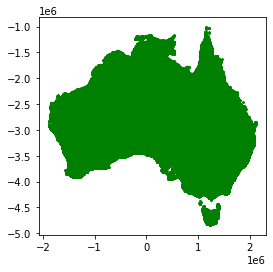

In [99]:
sjer_plots_points.plot(marker='*', color='green', markersize=5);

In [100]:
print(sjer_plots_points.geometry.bounds)
#print(sjer_plots_points.geometry.min())
print(np.shape(array_gdal))

             minx       miny       maxx       maxy
0       1151500.0 -1012500.0  1151500.0 -1012500.0
1       1156500.0 -1012500.0  1156500.0 -1012500.0
2       1156500.0 -1017500.0  1156500.0 -1017500.0
3       1161500.0 -1017500.0  1161500.0 -1017500.0
4       1201500.0 -1032500.0  1201500.0 -1032500.0
...           ...        ...        ...        ...
307499  1226500.0 -4832500.0  1226500.0 -4832500.0
307500  1231500.0 -4832500.0  1231500.0 -4832500.0
307501  1236500.0 -4832500.0  1236500.0 -4832500.0
307502  1241500.0 -4832500.0  1241500.0 -4832500.0
307503  1241500.0 -4837500.0  1241500.0 -4837500.0

[307504 rows x 4 columns]
(4100, 7401)


In [73]:
print(sjer_plots_points.loc[286607])
y=sjer_plots_points.geometry.y[286607]
x=sjer_plots_points.geometry.x[286607]

VALUE                              1
geometry    POINT (1711500 -3812500)
ind                     (2812, 5612)
Name: 286607, dtype: object


In [74]:
buff=700
b=np.ceil(buff/gt[1])
print(b)

1.0


In [75]:
ind=get_coords_at_point(gt,x,y)
print(ind)

(2812, 5612)


In [93]:
%%timeit
coregRasterSquare(ind[0], ind[1],array_gdal,b)

The slowest run took 10.64 times longer than the fastest. This could mean that an intermediate result is being cached.
2.79 µs ± 3.64 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [88]:
%%timeit
coregRaster(ind[0],ind[1],array_gdal,b)

43.9 µs ± 2.1 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [50]:
%%time
sjer_plots_points["ind"] = sjer_plots_points.apply(lambda x: get_coords_at_point(gt, x.geometry.x, x.geometry.y), axis=1)

Wall time: 49.2 s


In [42]:
sjer_plots_points.loc[286607,"ind"] #"ind"]
#df.loc[0,['A', 'B']]
#sjer_plots_points.iloc[::10, :]

sjer_plots_points.loc[999,"ind"][1]

4022

In [38]:
sjer_plots_points.loc[286607].geometry.x

1711500.0

In [46]:
pop=np.empty(len(sjer_plots_points))
pop[:] = np.NaN

In [43]:
%%time
for i,row in enumerate(sjer_plots_points.itertuples()):
	ind=get_coords_at_point(gt, row.geometry.x, row.geometry.y)

Wall time: 8.58 s


In [52]:
%%time
ind = sjer_plots_points.apply(lambda x: get_coords_at_point(gt, x.geometry.x, x.geometry.y), axis=1)

Wall time: 49.6 s


In [63]:
%%time
bag=db.from_sequence(ind)
val = bag.map(lambda x: coregRaster(x[0], x[1],array_gdal,b)).compute()

Wall time: 1min 39s


In [65]:
%%time
for i,row in enumerate(sjer_plots_points.itertuples()):
		ind=get_coords_at_point(gt, row.geometry.x, row.geometry.y)
		pop[i]=coregRaster(ind[0], ind[1], array_gdal,b)

c:\users\nbutter\miniconda3\envs\geopy\lib\site-packages\ipykernel_launcher.py:65: RuntimeWarning: invalid value encountered in double_scalars


Wall time: 17.5 s


Origin = (1692000.0, -3803000.0)
Pixel Size = (1000.0, -1000.0)


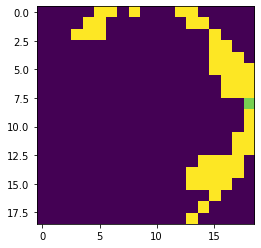

In [68]:
folder1=""
tiffile1="buffed.tif"

gdal_data1 = gdal.Open(folder1+tiffile1)

gdal_band1 = gdal_data1.GetRasterBand(1)
nodataval1 = gdal_band1.GetNoDataValue()
array_gdal1 = gdal_data1.ReadAsArray().astype(np.float)
gt1 = gdal_data1.GetGeoTransform()

plt.imshow(array_gdal1,vmin=0,vmax=1)

print("Origin = ({}, {})".format(gt1[0], gt1[3]))
print("Pixel Size = ({}, {})".format(gt1[1], gt1[5]))

In [69]:
1*1000*1000

1000000

In [70]:
1e6

1000000.0

In [101]:
popdens1=np.array([0.0147165,0.01632864,0.01413821,0.00955494,0.00906516])

In [104]:
popdens2=np.array([0.,0,0.,0.,0.])

In [105]:
print(popdens1.tolist())

[0.0147165, 0.01632864, 0.01413821, 0.00955494, 0.00906516]


In [98]:
pop=np.empty(5)

In [100]:
print(pop)

[17.2 17.2 17.2 17.2 24.2]
